In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.8 MB/s eta 0:00:00:00:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.9 MB/s eta 0:00:00:00:0100:01


In [4]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200):
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [11]:
urls = search_images('happy face photos', max_images = 1)
urls[0]

'https://www.designbolts.com/wp-content/uploads/2019/02/attractive-woman-free-stock-photo-1.jpg'

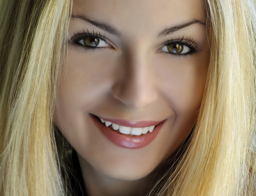

In [12]:
from fastdownload import download_url
dest = 'happyface.jpg'
download_url(urls[0], dest, show_progress = False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256)

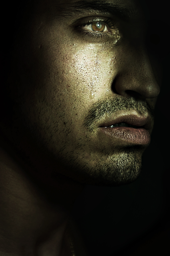

In [16]:
download_url(search_images('sad face photos', max_images = 1)[0], 'sadface.jpg', show_progress = False)
Image.open('sadface.jpg').to_thumb(256,256)

In [17]:
searches = 'happy face', 'sad face'
path = Path('happy_or_sad')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok = True, parents = True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [19]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

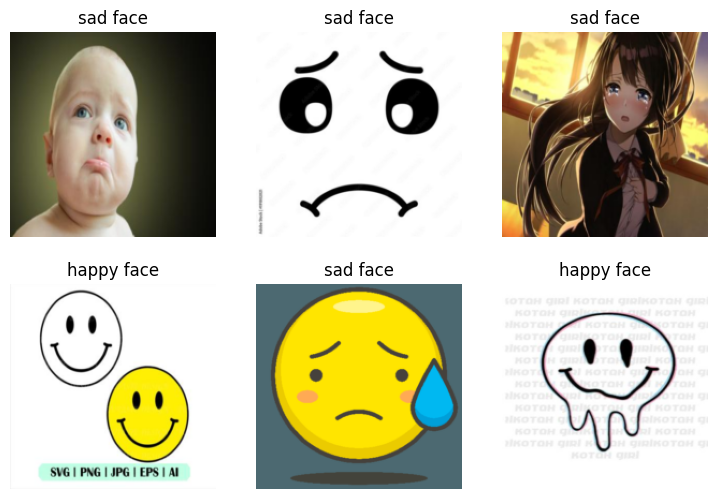

In [20]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [21]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.099136,0.691519,0.246575,00:39


epoch,train_loss,valid_loss,error_rate,time
0,0.662282,0.634830,0.232877,00:55
1,0.406638,0.433795,0.123288,00:37
2,0.301644,0.432965,0.109589,00:35
3,0.227865,0.433670,0.109589,00:55
4,0.204492,0.390207,0.123288,00:55
5,0.162042,0.381449,0.123288,00:55


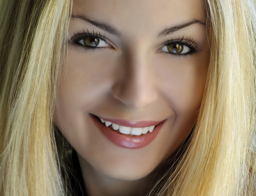

In [25]:
happy_example = PILImage.create('happyface.jpg')
happy_example.to_thumb(256)

In [26]:
is_happy,_,probs = learn.predict(happy_example)
print(f"This is a: {is_happy}.")
print(f"Probability it's a happy face: {probs[0]:.4f}")

This is a: happy face.
Probability it's a happy face: 0.9968


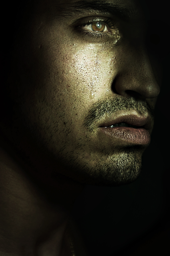

In [27]:
sad_example = PILImage.create('sadface.jpg')
sad_example.to_thumb(256)

In [28]:
is_happy,_,probs = learn.predict(PILImage.create('sadface.jpg'))
print(f"This is a: {is_happy}.")
print(f"Probability it's a happy face: {probs[0]:.4f}")

This is a: sad face.
Probability it's a happy face: 0.0000


In [30]:
!zip -r happy-sad-classifier.zip . -x "*.ipynb_checkpoints*"

updating: sadface.jpg (deflated 1%)
updating: happyface.jpg (deflated 0%)
updating: happy_or_sad/ (stored 0%)
updating: happy_or_sad/sad face/ (stored 0%)
updating: happy_or_sad/sad face/6752ce5d-71d8-401e-b7ed-babb75059a1d.jpg (deflated 9%)
updating: happy_or_sad/sad face/fe016f03-f04d-42b0-91da-7d8351f53163.jpeg (deflated 2%)
updating: happy_or_sad/sad face/03cde130-e661-485e-8eca-796848dea1d4.png (deflated 0%)
updating: happy_or_sad/sad face/be3404ba-c7f2-4c72-a94a-192817f04aaf.jpg (deflated 1%)
updating: happy_or_sad/sad face/07a77770-8a58-4496-bd62-e641b58c3793.jpg (deflated 7%)
updating: happy_or_sad/sad face/190c79bb-6d34-4189-9394-c3cb5ba60dfd.jpg (deflated 3%)
updating: happy_or_sad/sad face/f7f95bc6-3269-4b84-8167-f7f59df2a344.jpg (deflated 2%)
updating: happy_or_sad/sad face/38f8e9b2-3e9a-4708-aaa3-a74edfd6b95c.png (deflated 0%)
updating: happy_or_sad/sad face/6836d369-0ee7-4ef6-972a-6c6923622c7a.jpg (deflated 5%)
updating: happy_or_sad/sad face/05c9acca-bea7-498f-b155-e6a04